Initialize

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
from alive_progress import alive_bar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scripts import database
from scripts.BinanceClient import BinanceClient
from scripts.utils.symbol_selection import select_uncorrelated_symbols

1. Fetch and filter symbols

In [7]:
futures = BinanceClient(futures=True)
spot = BinanceClient(futures=False)

futures_symbols = futures.get_symbols()
spot_symbols = spot.get_symbols()

filtered_symbols = list(
    filter(
        futures.filter_symbols(min_years=3, contractType='PERPETUAL', status="TRADING", quoteAsset='USDT'),
        futures_symbols
    )
)

print("Spot Symbols:", len(spot_symbols))
print("Futures Symbols:", len(futures_symbols))
print("Filtered Futures Symbols:", len(filtered_symbols))

# intersection
symbol_names = [symbol['symbol'] for symbol in spot_symbols]
filtered_symbols = [symbol['symbol'] for symbol in filtered_symbols if symbol['symbol'] in symbol_names]

print("Filtered Common Symbols:", len(filtered_symbols))

Spot Symbols: 1257
Futures Symbols: 374
Filtered Futures Symbols: 118
Filtered Common Symbols: 105


2. Get close price and volume data for filtered symbols

In [ ]:
volume_price_data = {}  # symbol -> [[close], [volume]]

now = futures.current_time()
last_year = now - (365 * 24 * 3600 * 1000)  # 365 days behind

with alive_bar(len(filtered_symbols), force_tty=True) as bar:
    for symbol in filtered_symbols:
        symbol_data = futures.get_historical_data(symbol, '1d', start_time=last_year, end_time=now,
                                                  contract_type='PERPETUAL')
        volume_price_data[symbol] = [[], []]
        for data in symbol_data:
            volume_price_data[symbol][0].append(data[-2])  # close
            volume_price_data[symbol][1].append(data[-1])  # volume
        bar()

3. Select high volume symbols and their close price

In [35]:
sorted_volumes = sorted(volume_price_data.items(), key=lambda item: sum(item[1][1]) / len(item[1][1]), reverse=True)
num_symbol = int(0.6 * len(sorted_volumes))  # top 60%

top_liquid_symbols = {name: close for name, [close, vol] in sorted_volumes[:num_symbol]}

print('Symbols Chosen(by volume):', len(top_liquid_symbols))

Symbols Chosen(by volume): 63


4. Calculate correlation matrix

In [36]:
close_price_data = top_liquid_symbols
price_df = pd.DataFrame(close_price_data)

correlation_matrix = price_df.corr()

5. Select less correlated symbols

In [37]:
uncorrelated_symbols = select_uncorrelated_symbols(correlation_matrix)

database.write("symbols.csv", uncorrelated_symbols, replace=True)

6. Visualize correlation (heatmap)

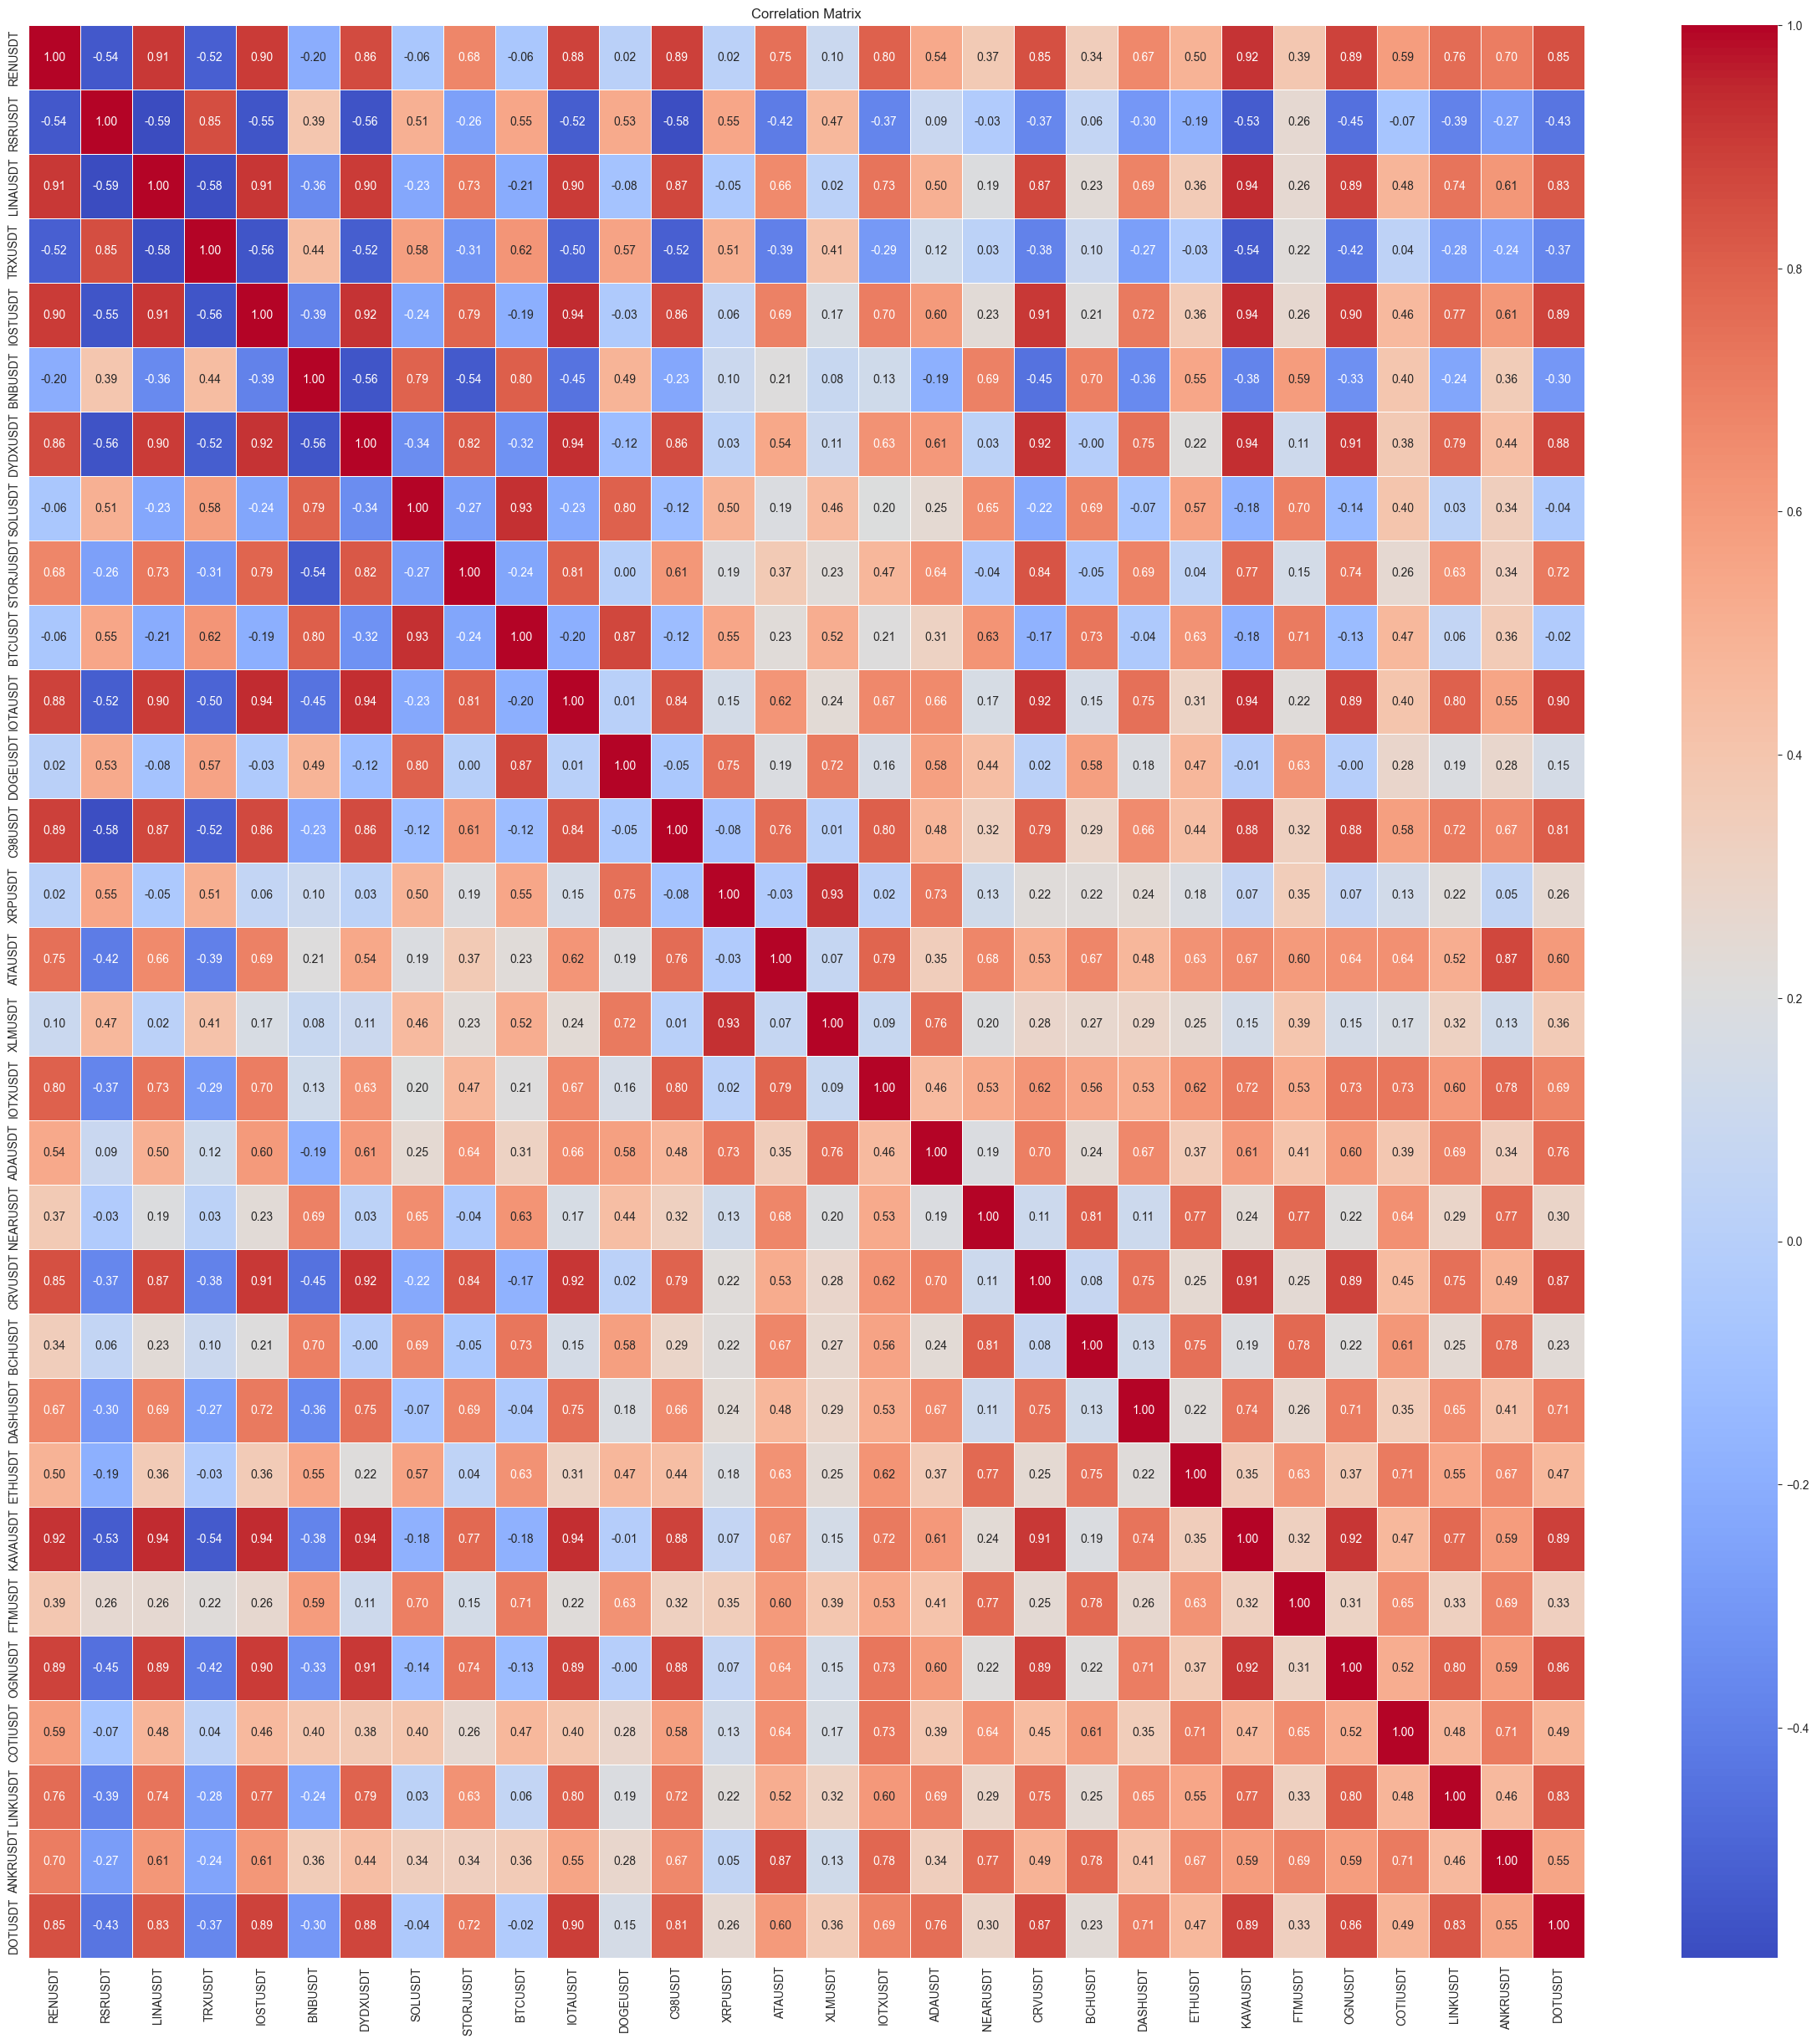

In [38]:
filtered_matrix = correlation_matrix.loc[uncorrelated_symbols, uncorrelated_symbols]

plt.figure(figsize=(len(filtered_matrix), len(filtered_matrix)))
sns.heatmap(filtered_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()